# Exercise 4: XGBoost

#### Sepideh Ghaemifar 2072829, Ehsan Eslami Shafigh 2070769, Abbas Zal 2072054, Poornima Amali Wickramasinghe 2088370

### importing Libraries

In [89]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree

##  Data Generation

In [131]:
    np.random.seed(123)

    CASE = 1

    S = 2
    N = 100
    N_train = 50
    N_test  = N - N_train
    x = S*(2*np.random.rand(N,2)-1)
    y = np.zeros(N).astype(int)

    for n in range(N):
        if CASE==1:
            if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
            if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
            if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
        elif CASE==2:
            if x[n,1]<0 and x[n,0]>0.5: y[n]=1
            if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1

    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]

[ 0.78587674 -0.85544266] 1
[-1.09259419  0.20525908] 0
[ 0.87787588 -0.30757416] 0
[1.92305679 0.73931895] 0
[-0.07627239 -0.43152993] 0


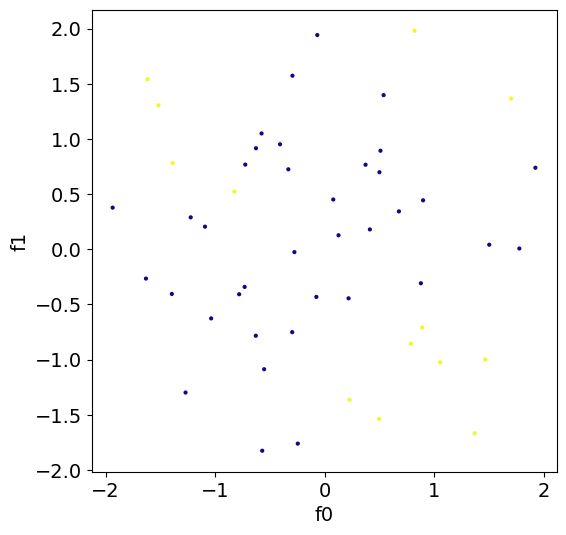

In [132]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

for n in range(5):
    print(x[n],y[n])

plt.figure(figsize=(6,6))
scat(x_train,y_train)
#scat(x_test,y_test,cmap="winter",s=7)
plt.show()

## DNN

In [133]:
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/2

x_train = Rescale(x_train)
x_test = Rescale(x_test)

In [134]:
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

L = 2

def create_DNN(activation, n_hidden_layers):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation=activation))
    
    for i in range(n_hidden_layers):
        model.add(Dense(20,activation=activation))   # 20 cells in each hidden layer
    
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
    
    return model


def model_compiler(optimizer ,activation, n_hidden_layers):
    model = create_DNN(activation, n_hidden_layers)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [26]:
# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'Adam' , 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']

# list of allowed optional arguments for the Activation Function
activation = ['relu', 'elu', 'tanh', 'sigmoid']

# List for Few deifferent number of hidden layers (otherwise the runnig time would get so much longer)
n_hidden_layers = [3,4]

# training parameters
batch_size = 64
epochs = 10

# GS estimator
model_gridsearch = KerasClassifier(
                        build_fn=model_compiler, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=1
                    )


param_grid = dict(optimizer = optimizer , activation = activation , n_hidden_layers = n_hidden_layers )

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4 , verbose = 4)  # Using 4_Cross_Validation
grid_result = grid.fit(x_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\PoD\AppData\Local\Temp\ipykernel_20904\439246911.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(


Fitting 4 folds for each of 56 candidates, totalling 224 fits
Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.6904 - accuracy: 0.6013
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6876 - accuracy: 0.6693
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5960
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5960
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6804 - accuracy: 0.5960
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6784 - accuracy: 0.5960
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6766 - accuracy: 0.5960
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.5960
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6726 - accuracy: 0.5960
Epoch 10/10
4/4 [==============================] - 0s 3m

Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.6900 - accuracy: 0.5920
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.6040
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.6040
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6726 - accuracy: 0.6040
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6653 - accuracy: 0.6040
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6587 - accuracy: 0.6040
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6040
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6392 - accuracy: 0.6040
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.6040
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.5760
[CV 4/4] END activati

12/12 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.6133
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.6400
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.6280
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.6160
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.6173
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6903 - accuracy: 0.6147
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.6120
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.6147
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.6147
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.5440
[CV 3/4] END activation=relu, n_

12/12 [==============================] - 1s 3ms/step - loss: 0.6898 - accuracy: 0.5733
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5733
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5733
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6813 - accuracy: 0.5733
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6793 - accuracy: 0.5733
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6782 - accuracy: 0.5733
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5733
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.5733
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6732 - accuracy: 0.5733
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6680
[CV 2/4] END activation=relu, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.5960
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5960
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5960
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5960
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.5960
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.5960
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5960
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6833 - accuracy: 0.5960
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5960
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6000
[CV 1/4] END activation=relu, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6896 - accuracy: 0.6373
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.6053
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.6040
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6616 - accuracy: 0.6080
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6461 - accuracy: 0.6600
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6275 - accuracy: 0.7027
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6070 - accuracy: 0.7453
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.5836 - accuracy: 0.7507
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.5653 - accuracy: 0.7493
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.5755 - accuracy: 0.7240
[CV 4/4] END activation=relu, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6926 - accuracy: 0.6080
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.6147
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.6147
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.6147
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.6147
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.6147
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.6147
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.6147
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.6147
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5440
[CV 3/4] END activation=relu, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6920 - accuracy: 0.5667
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5733
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5733
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5733
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5733
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.5733
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.5733
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6831 - accuracy: 0.5733
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6819 - accuracy: 0.5733
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.6680
[CV 2/4] END activation=relu, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6876 - accuracy: 0.5627
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.6093
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6782 - accuracy: 0.5973
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.5960
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.5960
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.5960
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.5960
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6720 - accuracy: 0.5960
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.5960
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.6000
[CV 1/4] END activation=elu, n_h

12/12 [==============================] - 1s 2ms/step - loss: 0.6784 - accuracy: 0.6653
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6628 - accuracy: 0.6840
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6720
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6444 - accuracy: 0.6733
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6395 - accuracy: 0.6747
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6346 - accuracy: 0.6787
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6301 - accuracy: 0.6640
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6242 - accuracy: 0.6733
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6162 - accuracy: 0.6693
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6242 - accuracy: 0.6440
[CV 4/4] END activation=elu, n_h

12/12 [==============================] - 1s 2ms/step - loss: 0.6871 - accuracy: 0.4720
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.4587
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.4680
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6820 - accuracy: 0.4800
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.4947
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.5200
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6785 - accuracy: 0.5293
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.5427
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6762 - accuracy: 0.5587
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6760 - accuracy: 0.5680
[CV 3/4] END activation=elu, n_h

12/12 [==============================] - 1s 2ms/step - loss: 0.6892 - accuracy: 0.6107
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6830 - accuracy: 0.7067
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6781 - accuracy: 0.7093
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6761 - accuracy: 0.6907
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6736 - accuracy: 0.6933
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.6787
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6696 - accuracy: 0.6813
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.6840
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6665 - accuracy: 0.6867
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.7600
[CV 2/4] END activation=elu, n_h

12/12 [==============================] - 1s 3ms/step - loss: 0.6962 - accuracy: 0.4507
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5080
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5933
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.5960
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6823 - accuracy: 0.5960
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6809 - accuracy: 0.5960
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6800 - accuracy: 0.5960
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5960
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.5960
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6000
[CV 1/4] END activation=elu, n_h

12/12 [==============================] - 1s 2ms/step - loss: 0.6807 - accuracy: 0.5627
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6594 - accuracy: 0.6040
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6227
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6476 - accuracy: 0.6360
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6463 - accuracy: 0.6600
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6448 - accuracy: 0.6507
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6424 - accuracy: 0.6587
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6382 - accuracy: 0.6680
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.6493
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6320
[CV 4/4] END activation=elu, n_h

12/12 [==============================] - 1s 2ms/step - loss: 0.6952 - accuracy: 0.5427
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5827
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.5747
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6866 - accuracy: 0.5773
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5640
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.5640
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.5600
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6805 - accuracy: 0.5573
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5640
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.4840
[CV 3/4] END activation=elu, n_h

12/12 [==============================] - 1s 3ms/step - loss: 0.6837 - accuracy: 0.5360
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5640
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6697 - accuracy: 0.5800
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6672 - accuracy: 0.5813
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.5907
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6650 - accuracy: 0.5987
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.6040
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6622 - accuracy: 0.6147
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6173
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6160
[CV 2/4] END activation=elu, n_h

12/12 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.5680
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5960
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.5960
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6765 - accuracy: 0.5960
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6749 - accuracy: 0.5960
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6737 - accuracy: 0.5960
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6730 - accuracy: 0.5960
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.5960
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6716 - accuracy: 0.5960
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.6000
[CV 1/4] END activation=tanh, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6768 - accuracy: 0.6867
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6620 - accuracy: 0.6880
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6531 - accuracy: 0.6920
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6526 - accuracy: 0.6947
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6507 - accuracy: 0.6920
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.6880
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6482 - accuracy: 0.6813
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6440 - accuracy: 0.6800
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.6827
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6554 - accuracy: 0.6520
[CV 4/4] END activation=tanh, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6990 - accuracy: 0.4507
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.5120
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5427
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6896 - accuracy: 0.5680
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy: 0.5920
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.6147
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6847 - accuracy: 0.6133
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6833 - accuracy: 0.6147
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6820 - accuracy: 0.6147
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5440
[CV 3/4] END activation=tanh, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6675 - accuracy: 0.6947
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6596 - accuracy: 0.7027
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.6813
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.6760
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6544 - accuracy: 0.6787
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6539 - accuracy: 0.6680
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.6760
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.6893
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6530 - accuracy: 0.6893
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6469 - accuracy: 0.6440
[CV 2/4] END activation=tanh, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6864 - accuracy: 0.6387
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.6013
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6775 - accuracy: 0.5960
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6751 - accuracy: 0.5960
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6735 - accuracy: 0.5960
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.5960
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6718 - accuracy: 0.5960
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.5960
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6707 - accuracy: 0.5960
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.6000
[CV 1/4] END activation=tanh, n_

12/12 [==============================] - 1s 3ms/step - loss: 0.6848 - accuracy: 0.5760
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.6040
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6067
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.6187
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6267
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6093
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6427
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6547
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6360
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6400
[CV 4/4] END activation=tanh, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6895 - accuracy: 0.4920
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5640
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6819 - accuracy: 0.6053
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.6467
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6775 - accuracy: 0.6387
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6759 - accuracy: 0.6173
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.6160
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6734 - accuracy: 0.6160
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.6147
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5440
[CV 3/4] END activation=tanh, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.6837 - accuracy: 0.6067
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6702 - accuracy: 0.6120
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6630 - accuracy: 0.6160
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6107
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6589 - accuracy: 0.6053
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6593 - accuracy: 0.6053
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6580 - accuracy: 0.5973
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.5893
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.5920
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.5920
[CV 2/4] END activation=tanh, n_

12/12 [==============================] - 1s 2ms/step - loss: 0.9436 - accuracy: 0.4040
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.8591 - accuracy: 0.4040
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7971 - accuracy: 0.4040
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7627 - accuracy: 0.4040
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7336 - accuracy: 0.4013
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7136 - accuracy: 0.4093
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7004 - accuracy: 0.4200
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6917 - accuracy: 0.5400
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5893
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6000
[CV 1/4] END activation=sigmoid,

12/12 [==============================] - 1s 2ms/step - loss: 0.8377 - accuracy: 0.6040
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7610 - accuracy: 0.6040
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7147 - accuracy: 0.6040
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.6040
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.6040
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6691 - accuracy: 0.6040
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.6040
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6732 - accuracy: 0.6027
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6718 - accuracy: 0.6040
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5760
[CV 4/4] END activation=sigmoid,

12/12 [==============================] - 1s 2ms/step - loss: 0.6708 - accuracy: 0.6147
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6147
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6703 - accuracy: 0.6147
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6160
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6147
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6147
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6672 - accuracy: 0.6133
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.6147
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.6147
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.5440
[CV 3/4] END activation=sigmoid,

12/12 [==============================] - 1s 2ms/step - loss: 0.6975 - accuracy: 0.4653
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.5627
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.5640
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.5747
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6828 - accuracy: 0.5707
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6830 - accuracy: 0.5707
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.5693
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.5733
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6813 - accuracy: 0.5733
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6548 - accuracy: 0.6680
[CV 2/4] END activation=sigmoid,

12/12 [==============================] - 1s 3ms/step - loss: 0.7225 - accuracy: 0.4000
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.4187
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.4360
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.5827
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.5867
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6845 - accuracy: 0.5827
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6820 - accuracy: 0.5813
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6793 - accuracy: 0.5973
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6762 - accuracy: 0.5947
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6000
[CV 1/4] END activation=sigmoid,

12/12 [==============================] - 1s 2ms/step - loss: 0.6750 - accuracy: 0.6027
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6743 - accuracy: 0.6040
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.6040
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6724 - accuracy: 0.6013
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.6040
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6732 - accuracy: 0.6040
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6739 - accuracy: 0.6053
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.6013
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6720 - accuracy: 0.6040
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5760
[CV 4/4] END activation=sigmoid,

12/12 [==============================] - 1s 3ms/step - loss: 0.6739 - accuracy: 0.6093
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.6147
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6705 - accuracy: 0.6147
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.6093
Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.6147
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6133
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.6120
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6689 - accuracy: 0.6120
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.6147
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5440
[CV 3/4] END activation=sigmoid,

12/12 [==============================] - 1s 2ms/step - loss: 0.7479 - accuracy: 0.4280
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7166 - accuracy: 0.4347
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.7015 - accuracy: 0.4333
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.5693
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6865 - accuracy: 0.5640
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.5693
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6834 - accuracy: 0.5693
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6835 - accuracy: 0.5707
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5720
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 0.6555 - accuracy: 0.6680
[CV 2/4] END activation=sigmoid,

16/16 [==============================] - 1s 2ms/step - loss: 0.6922 - accuracy: 0.5230
Epoch 2/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5970
Epoch 3/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6763 - accuracy: 0.5970
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6669 - accuracy: 0.5970
Epoch 5/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6575 - accuracy: 0.5970
Epoch 6/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6467 - accuracy: 0.5970
Epoch 7/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.5970
Epoch 8/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6211 - accuracy: 0.5970
Epoch 9/10
16/16 [==============================] - 0s 2ms/step - loss: 0.6077 - accuracy: 0.5970
Epoch 10/10
16/16 [==============================] - 0s 2ms/step - loss: 0.5948 - accuracy: 0.5970
Best: 0.686000 using {'activat

In [135]:
grid_result.best_params_

{'activation': 'relu', 'n_hidden_layers': 4, 'optimizer': 'Adam'}

In [136]:
FINAL_MODEL = model_compiler( 'RMSprop','elu',4 )

In [156]:
fit = FINAL_MODEL.fit(x_train, y_train,
               epochs = 400, batch_size = 50,
               validation_data=(x_test,y_test),
               verbose=0)


In [161]:
print(fit.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [164]:
fit.history['val_loss'][-1]

0.16434656083583832

In [151]:
dX = 0.1
X1 = np.arange(-1,1+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid

pred = FINAL_MODEL.predict(grid_r)

41 1681
[2. 2.]
53/53 [==============================] - 0s 3ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

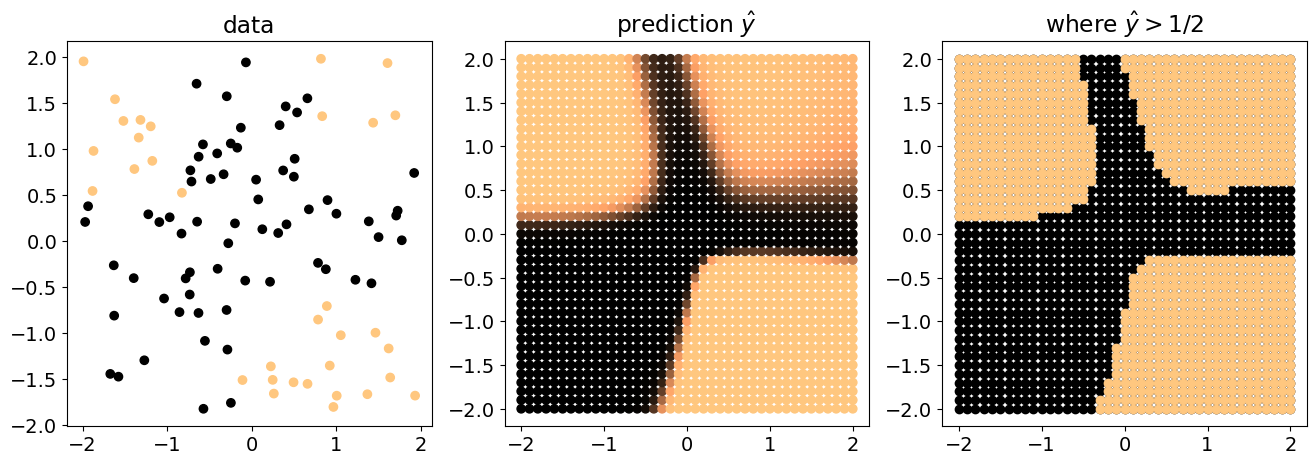

In [152]:
def boundaries():  
    x1=-25
    y1=-35
    c="#AAAAFF"
    a=0.5
    lw=5
    ax.plot((50,-20),(-20,50),c=c,alpha=a,lw=lw)
    ax.plot((50,0),(0,50),c=c,alpha=a,lw=lw)
    ax.plot((x1,50),(y1,y1),c=c,alpha=a,lw=lw)
    ax.plot((x1,x1),(y1,50),c=c,alpha=a,lw=lw)
    
fig,AX=plt.subplots(1,3,figsize=(16,5))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
#boundaries()
ax.set_title("data")

ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
#boundaries()
ax.set_title("prediction $\\hat y$")

ax=AX[2]
W1=np.where(pred>0.5)[0]                      #**
ax.scatter(grid[:,0],grid[:,1],c="#000000")
ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
#boundaries()
ax.set_title("where $\\hat y > 1/2$")
plt.show


## XGBoost

In [140]:
np.random.seed(123)

CASE = 1

S = 2
N = 100
N_train = 50
N_test  = N - N_train
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)

for n in range(N):
    if CASE==1:
        if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
        if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
        if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
    elif CASE==2:
        if x[n,1]<0 and x[n,0]>0.5: y[n]=1
        if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1

x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

In [141]:
import numpy as np
import matplotlib.pyplot as plt
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier

plt.rcParams['font.size'] = 14


def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    if CASE<10: print("errors: {:.2f}%".format(100*(1-clf.score(x_test, y_test))))

    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    #plt.figure(figsize=(6,6))
    #plt.title(str(clf))

    #scat(x_plot,y_plot,cmap="winter",s=1)
    #scat(x_train,y_train,s=7)
    #plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()
        
    return (1-clf.score(x_test, y_test))

errors: 14.00%


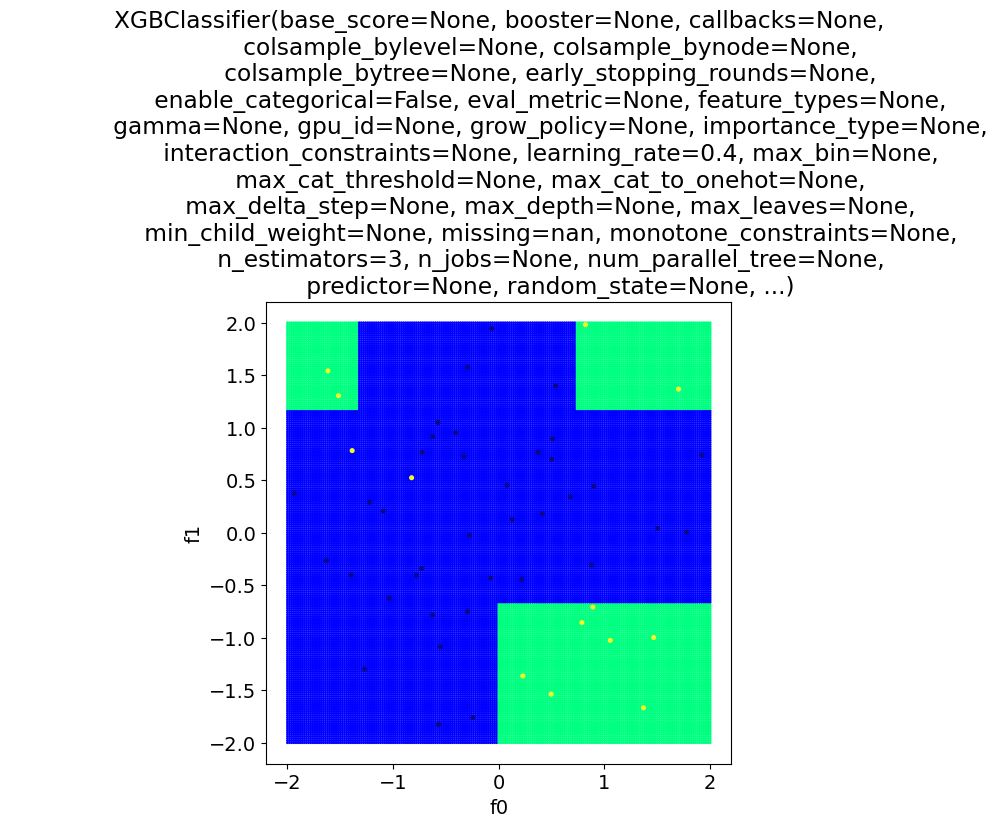

0.14

In [142]:
classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=0.001, n_estimators=3),show=False)

errors: 2.00%


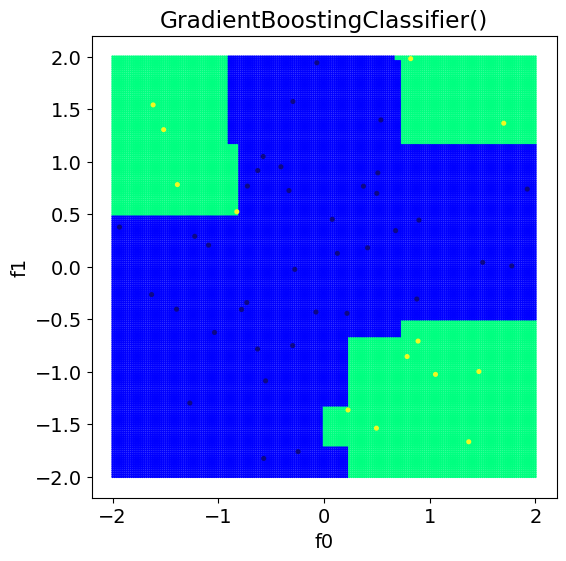

0.020000000000000018

In [143]:
# GradientBoostingClassifier():
classify()

errors: 10.00%


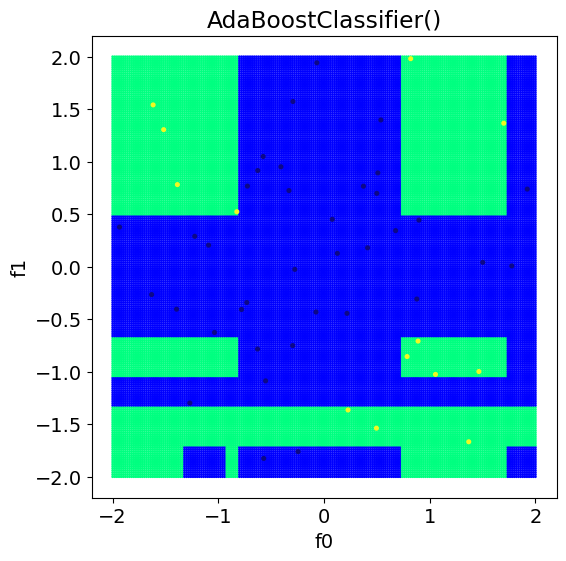

0.09999999999999998

In [144]:
classify(clf=AdaBoostClassifier())

gamma: 0.0 lambda: 100.0 n: 10
errors: 26.00%


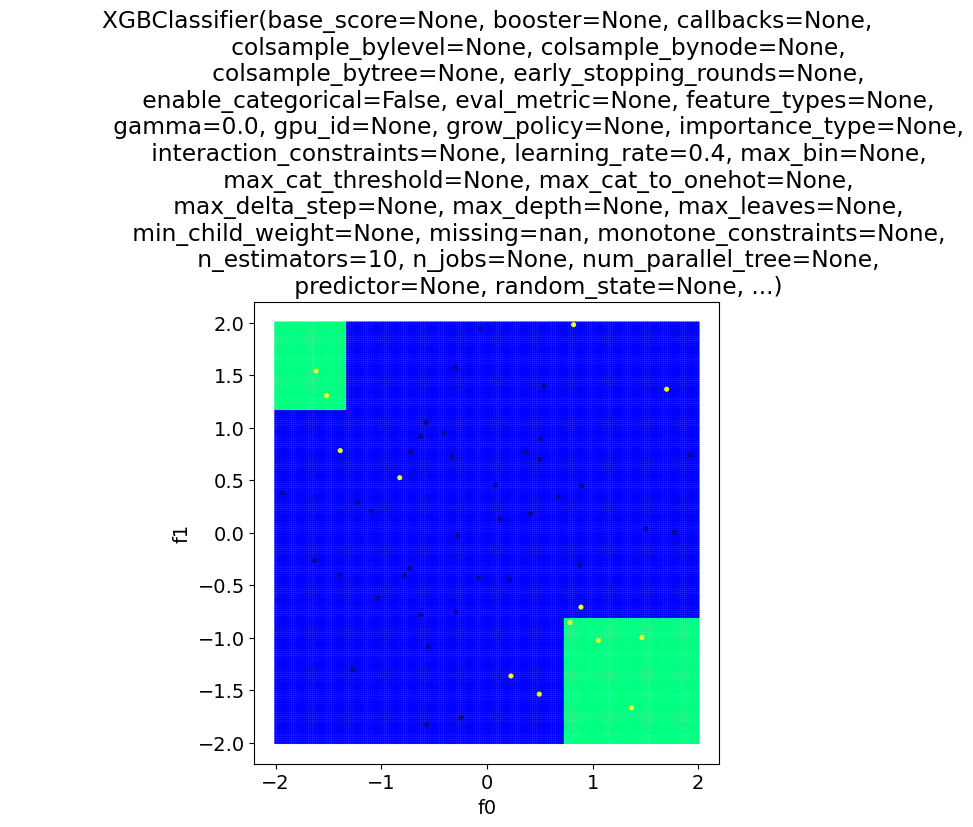

gamma: 0.0 lambda: 100.0 n: 20
errors: 26.00%


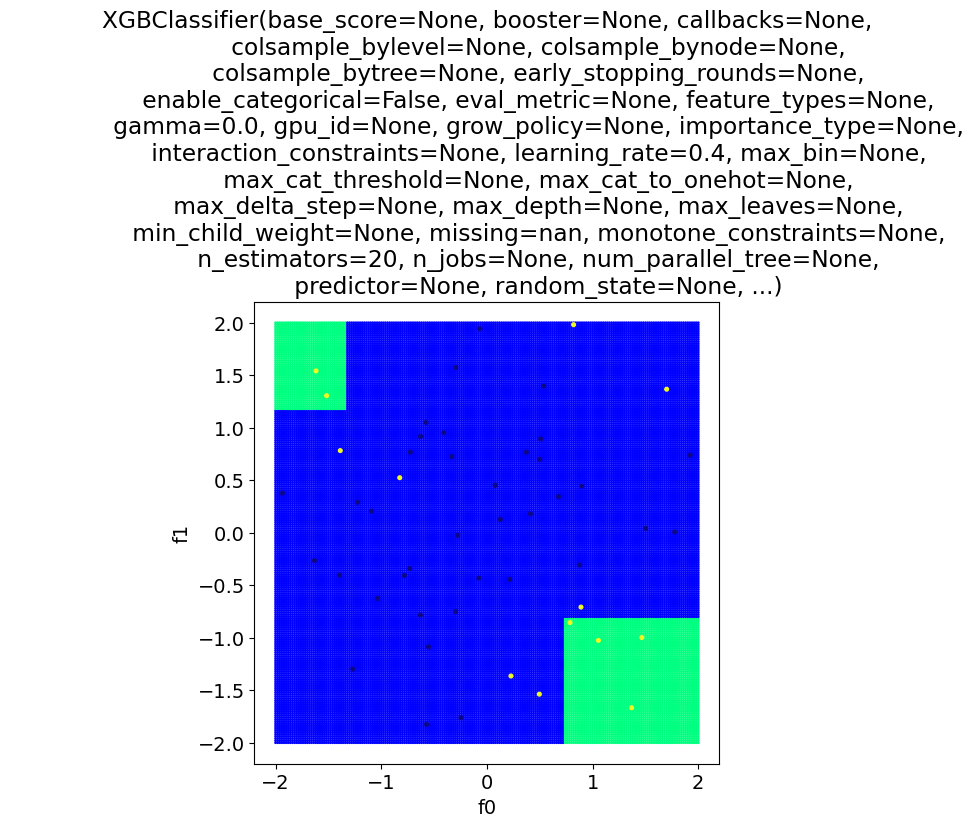

gamma: 0.0 lambda: 100.0 n: 30
errors: 26.00%


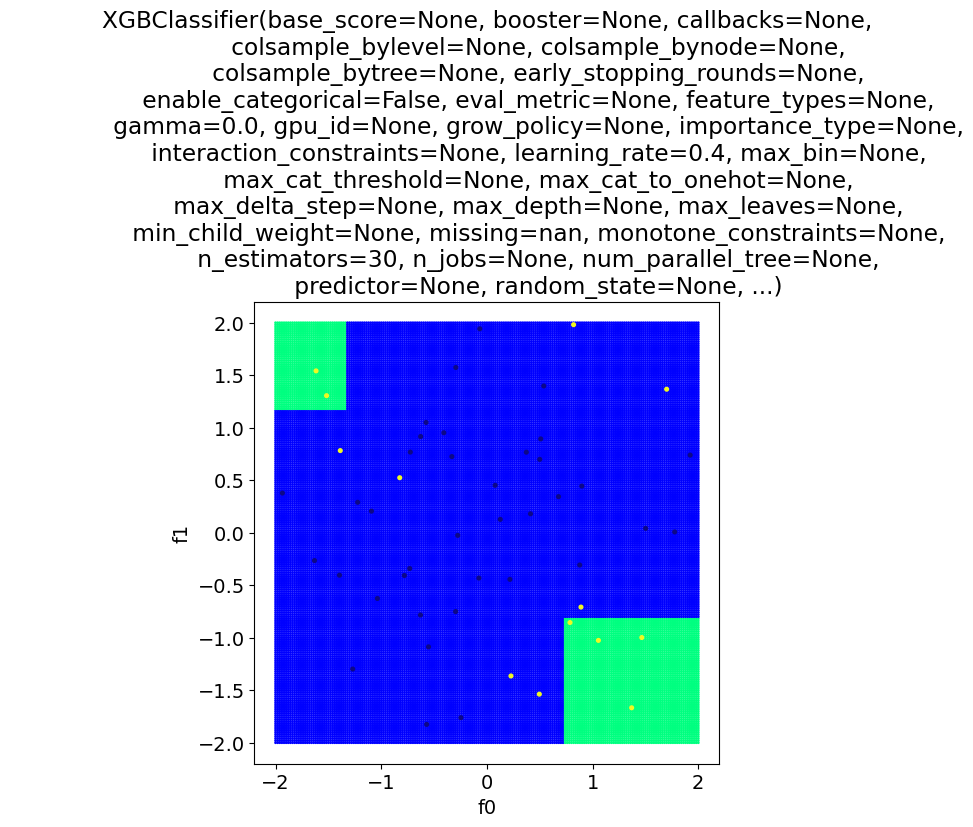

gamma: 0.0 lambda: 100.0 n: 40
errors: 26.00%


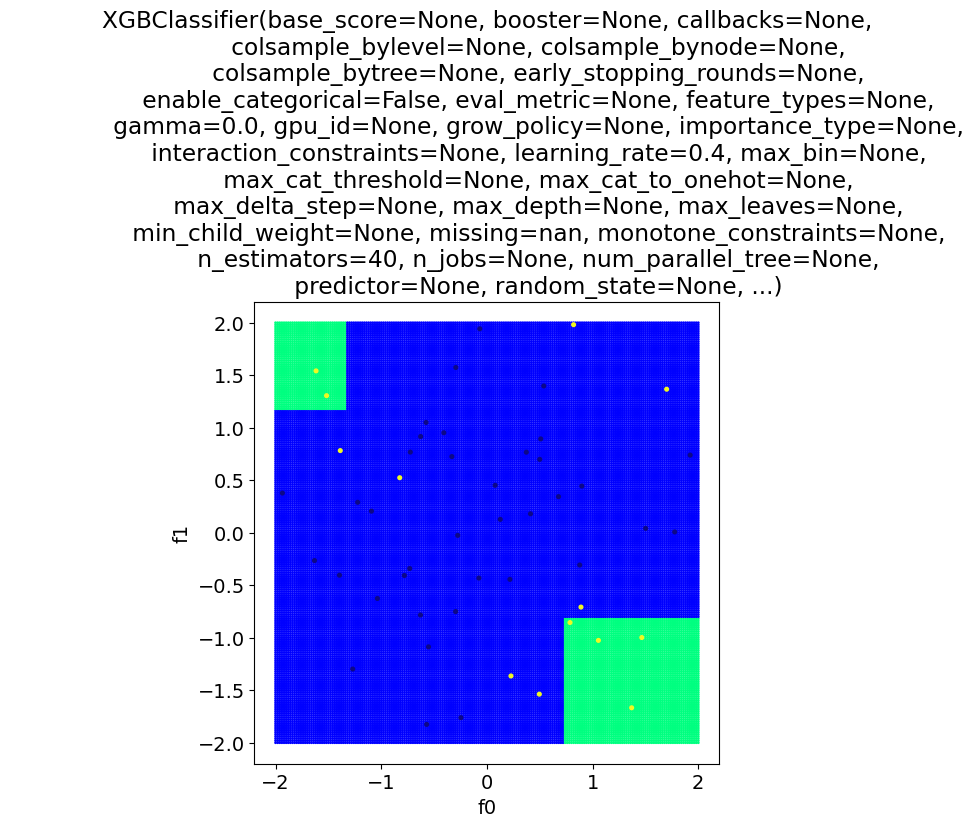

gamma: 0.0 lambda: 100.0 n: 50
errors: 26.00%


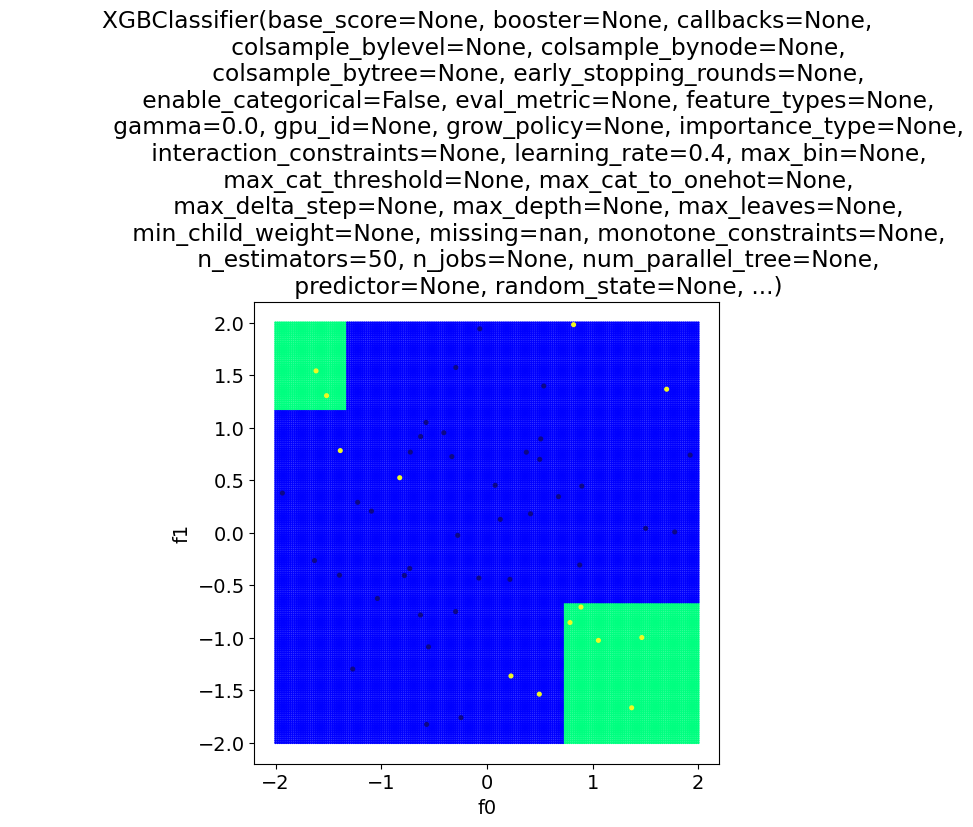

gamma: 0.0 lambda: 100.0 n: 60
errors: 26.00%


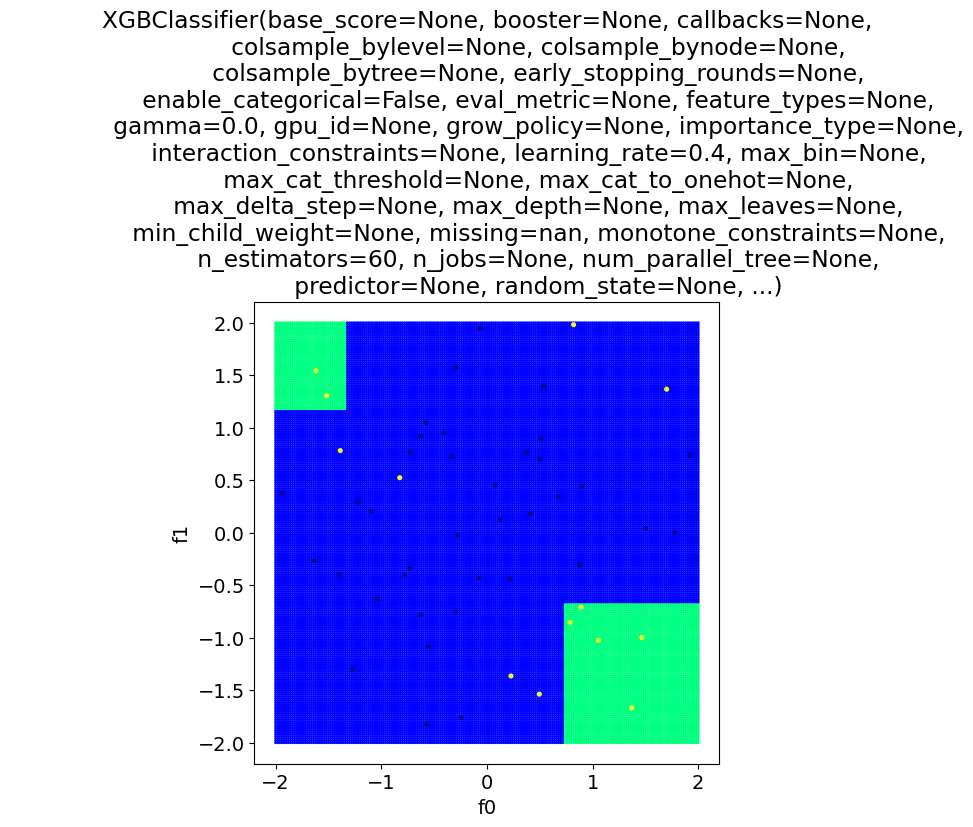

gamma: 0.0 lambda: 100.0 n: 70
errors: 26.00%


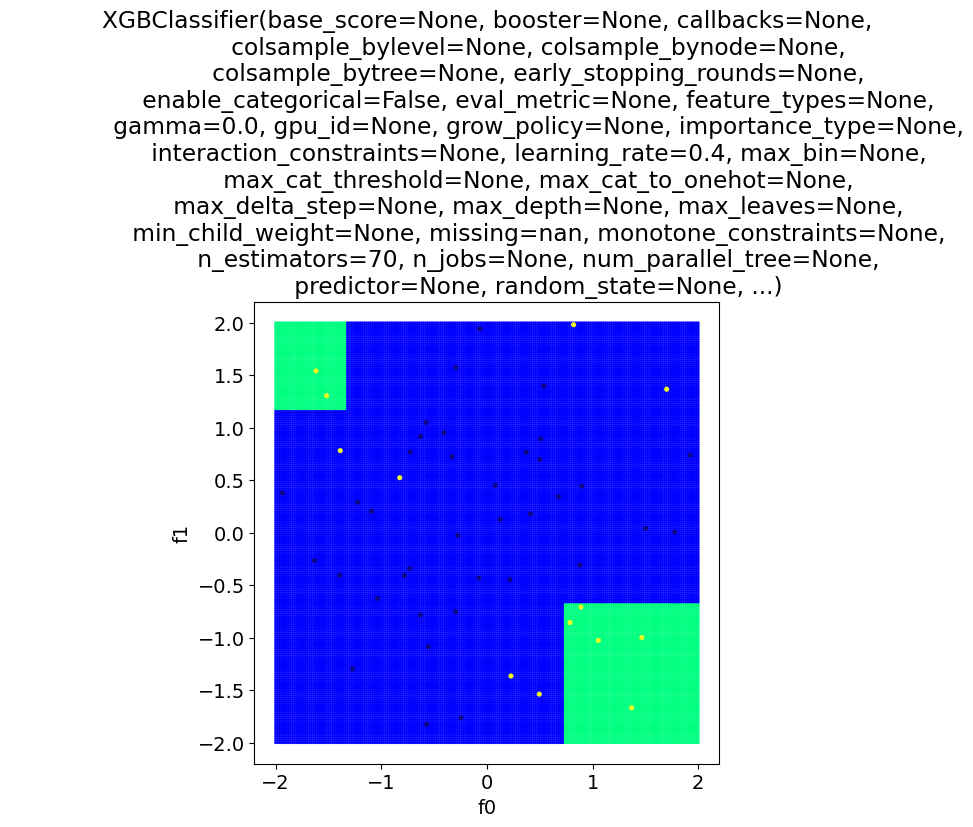

gamma: 0.0 lambda: 100.0 n: 80
errors: 24.00%


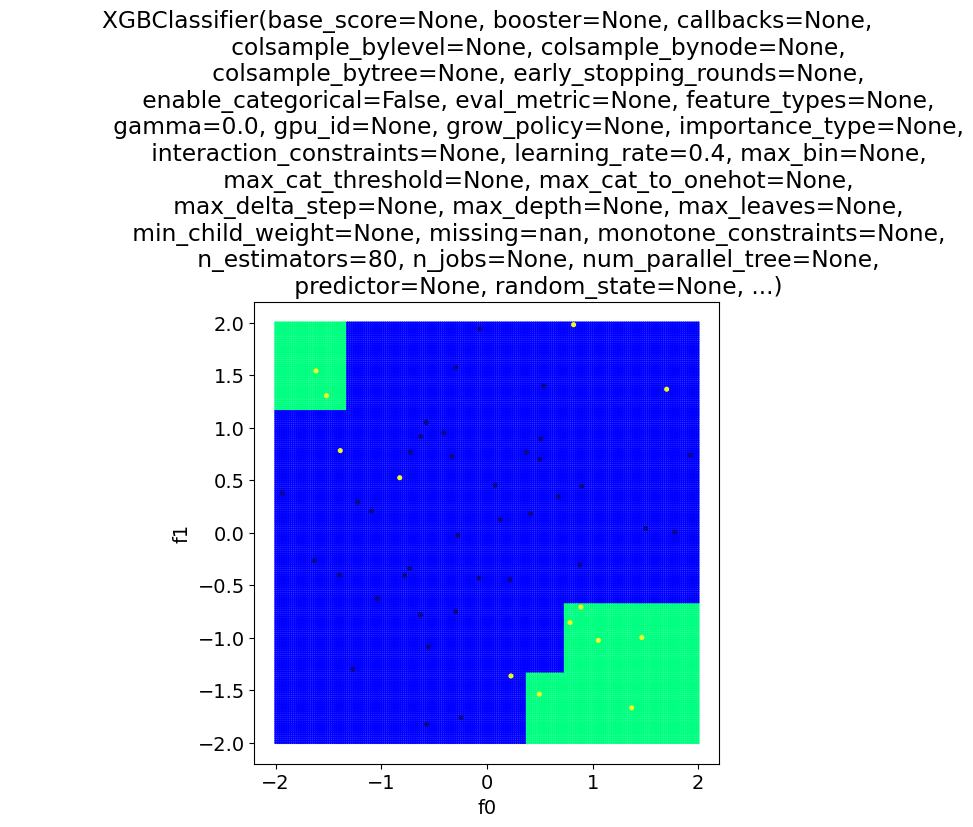

gamma: 0.0 lambda: 100.0 n: 90
errors: 20.00%


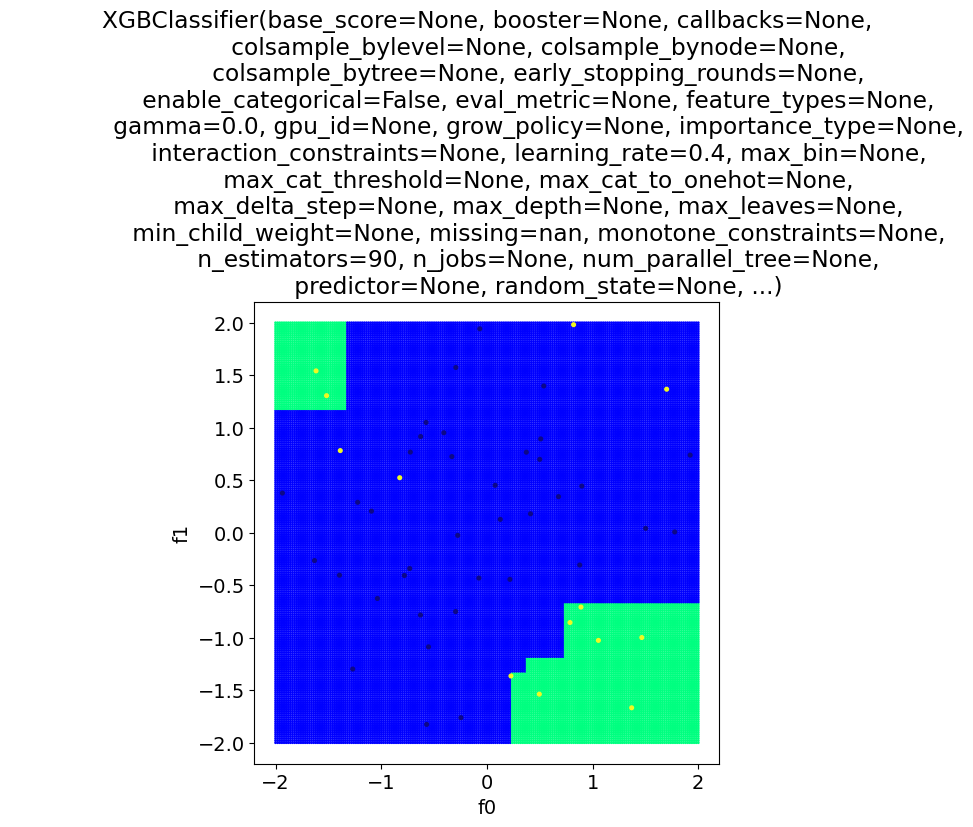

gamma: 0.0 lambda: 100.0 n: 100
errors: 20.00%


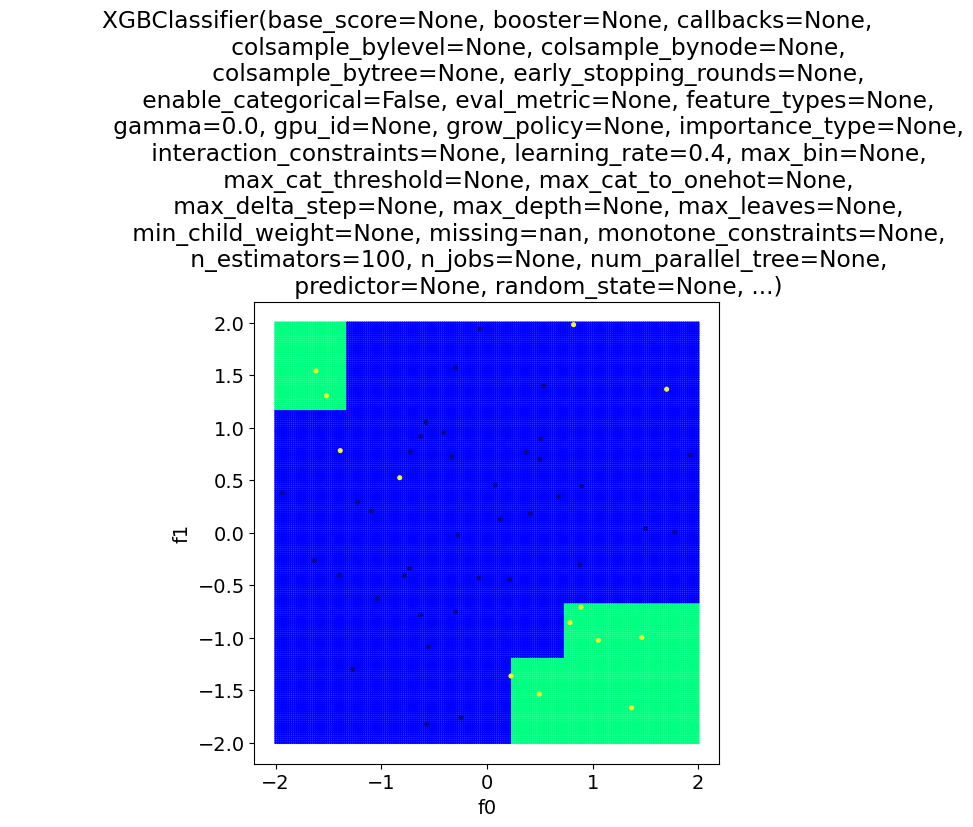

gamma: 1.0 lambda: 100.0 n: 10
errors: 40.00%


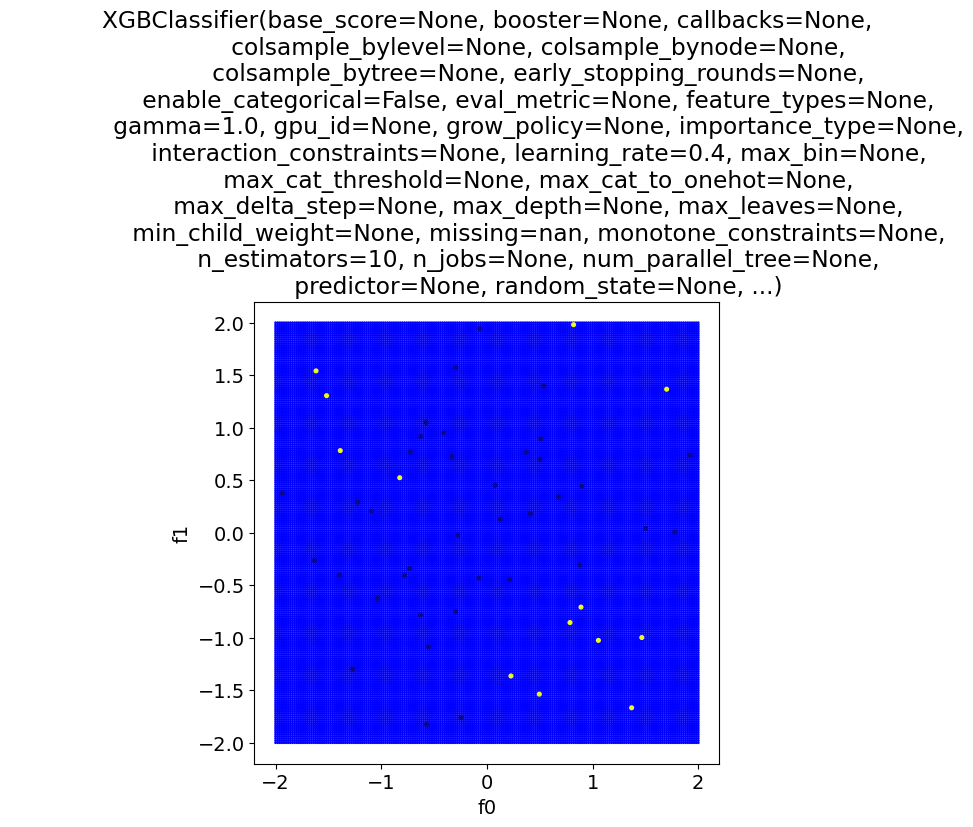

gamma: 1.0 lambda: 100.0 n: 20
errors: 40.00%


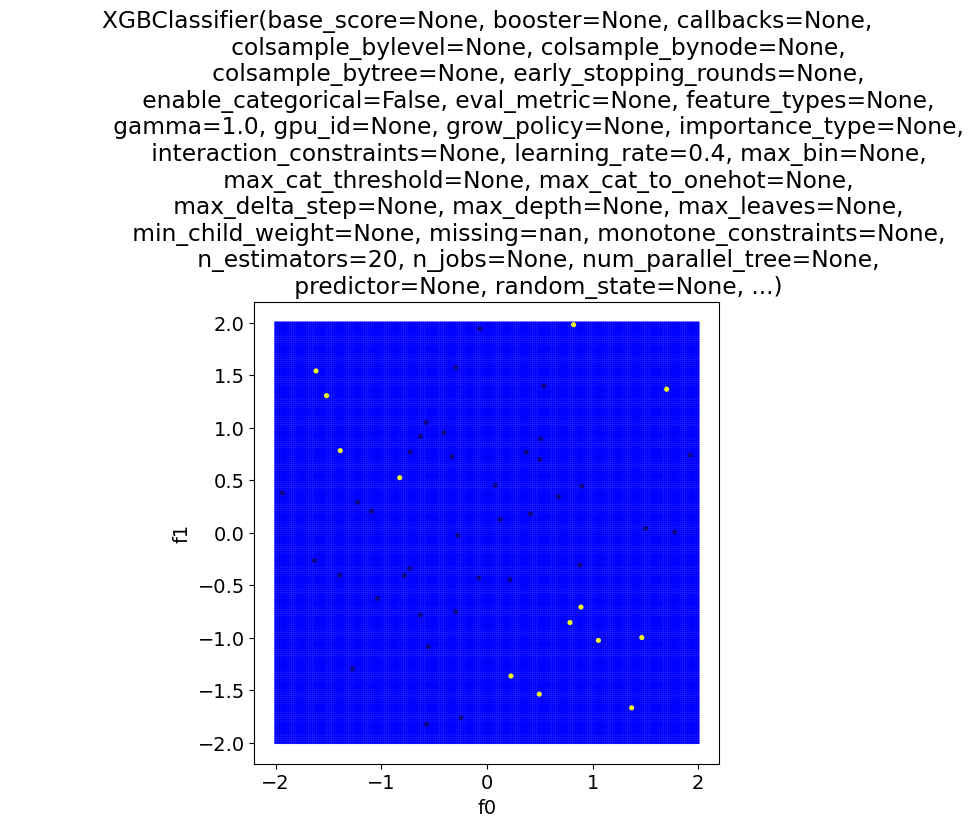

gamma: 1.0 lambda: 100.0 n: 30
errors: 40.00%


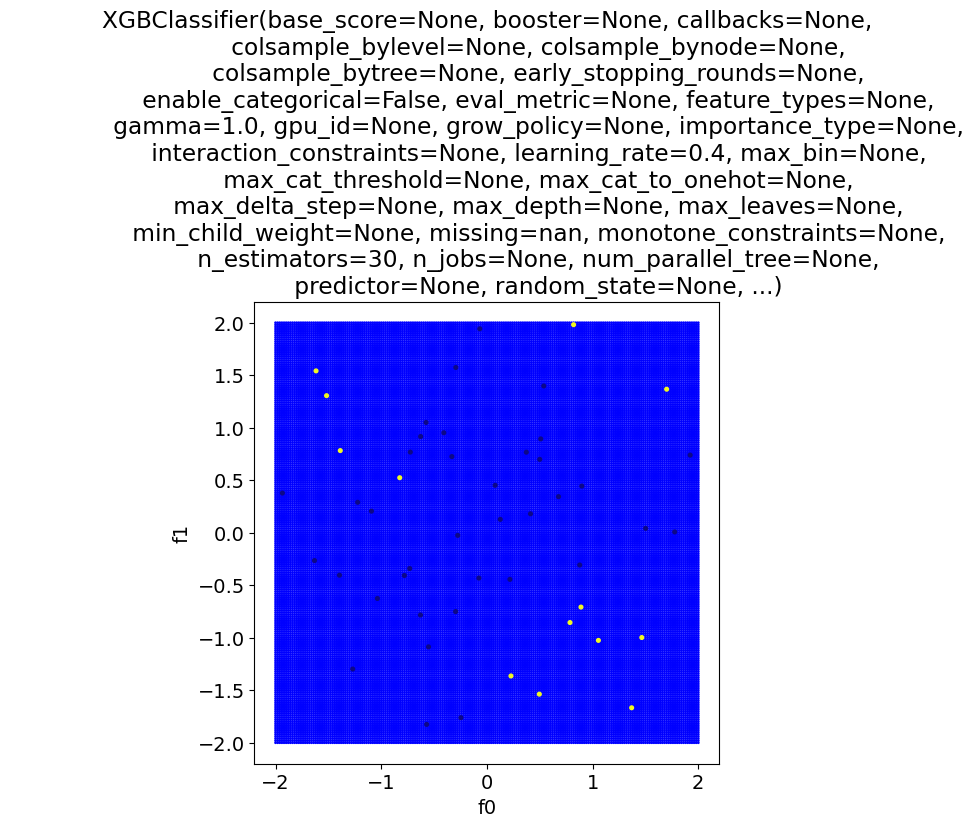

gamma: 1.0 lambda: 100.0 n: 40
errors: 40.00%


KeyboardInterrupt: 

<Figure size 600x600 with 0 Axes>

In [145]:
lam=[100.,30,20.,10.,5.,1.,0.5,0.1]
gam=[0.,1.,2.,4.,10.,20.,40.,100.,200.]
n_estimators = [10,20,30,40,50,60,70,80,90,100]
params = []
for l in lam:
    for g in gam:
        for n in n_estimators:
            
            print("gamma:" , g , "lambda:" , l , "n:" , n)
            err = classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=l, n_estimators=n , gamma = g),show=False)
            params.append([l , g , n , err])


In [146]:
params = np.array(params)
np.set_printoptions(suppress = True)
params[np.argmin(params[: , 3])]

array([100. ,   0. ,  90. ,   0.2])